In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
from xgboost import XGBRegressor, XGBClassifier

from econml.dml import LinearDML

In [3]:
# Install the package for calling R from python
#%pip install rpy2
## activate R magic
%load_ext rpy2.ipython
import rpy2
## Install packages in R if needed
#%R install.packages('hdm')
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

## Savings and 401k Plans
The sample is drawn from the 1991 Survey of Income and Program Participation (SIPP) and consists
of 9,915 observations. The observational units are household reference persons aged 25-64 and
spouse if present. Households are included in the sample if at least one person is employed and no
one is self-employed. The data set was analysed in Chernozhukov and Hansen (2004) and Belloni
et al. (2014) where further details can be found. They examine the effects of 401(k) plans on
wealth using data from the Survey of Income and Program Participation using 401(k) eligibility as
an instrument for 401(k) participation.

* p401 = participation in 401(k)
* e401 = eligibility for 401(k)
* a401 = 401(k) assets
* tw = total wealth (in US $)
* tfa = financial assets (in US $)
* net_tfa = net financial assets (in US $)
* nifa = non-401k financial assets (in US $)
* net_nifa = net non-401k financial assets
* net_n401 = net non-401(k) assets (in US $)
* ira = individual retirement account (IRA)
* inc = income (in US $)
* age = age
* fsize = family size
* marr = married
* pira = participation in IRA
* db = defined benefit pension
* hown = home owner
* educ = education (in years)
* male = male
* twoearn = two earners
* nohs, = hs, smcol, col dummies for education: no high-school, high-school, some college, college
* hmort = home mortage (in US $)
* hequity = home equity (in US $)
* hval = home value (in US $)

In [4]:
# Load dataset from R package and return as a pandas dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
    df = ro.conversion.rpy2py(rpy2.robjects.packages.PackageData('hdm').fetch('pension')['pension'])
df

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,...,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
1,0,0,69000,60150,8850,100,-3300,100,-3300,5550,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0,78000,20000,58000,61010,61010,61010,61010,119010,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1800,0,200000,15900,184100,7549,7049,9349,8849,192949,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,0,0,0,0,2487,-6013,2487,-6013,-6013,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0,0,300000,90000,210000,10625,-2375,10625,-2375,207625,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9911,0,172,0,0,0,0,0,172,172,172,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9912,0,4500,53000,49000,4000,936,-3664,5436,836,4836,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9913,0,0,250000,150000,100000,10150,6150,10150,6150,106150,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9914,0,15000,63000,59000,4000,3499,-501,18499,14499,18499,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
T = 'e401'
Y = 'net_tfa'
X = ['age', 'inc', 'fsize', 'educ', 'pira', 'hown', 'marr', 'db', 'twoearn']

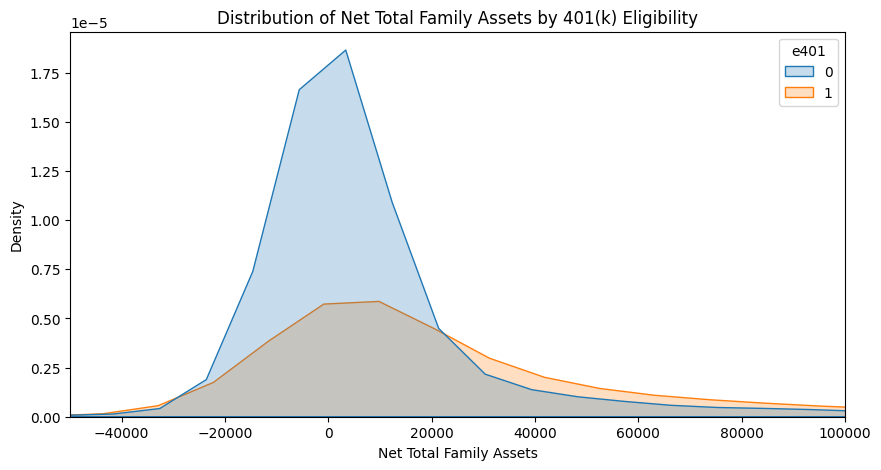

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.kdeplot(df, x="net_tfa", hue="e401", fill=True, ax=ax)
ax.set_xlim(-50000, 100000)
ax.set_xlabel("Net Total Family Assets")
ax.set_title("Distribution of Net Total Family Assets by 401(k) Eligibility");
#sns.displot(df, x="net_tfa", hue="e401", kind="hist", fill=True, log_scale=(False, True) )

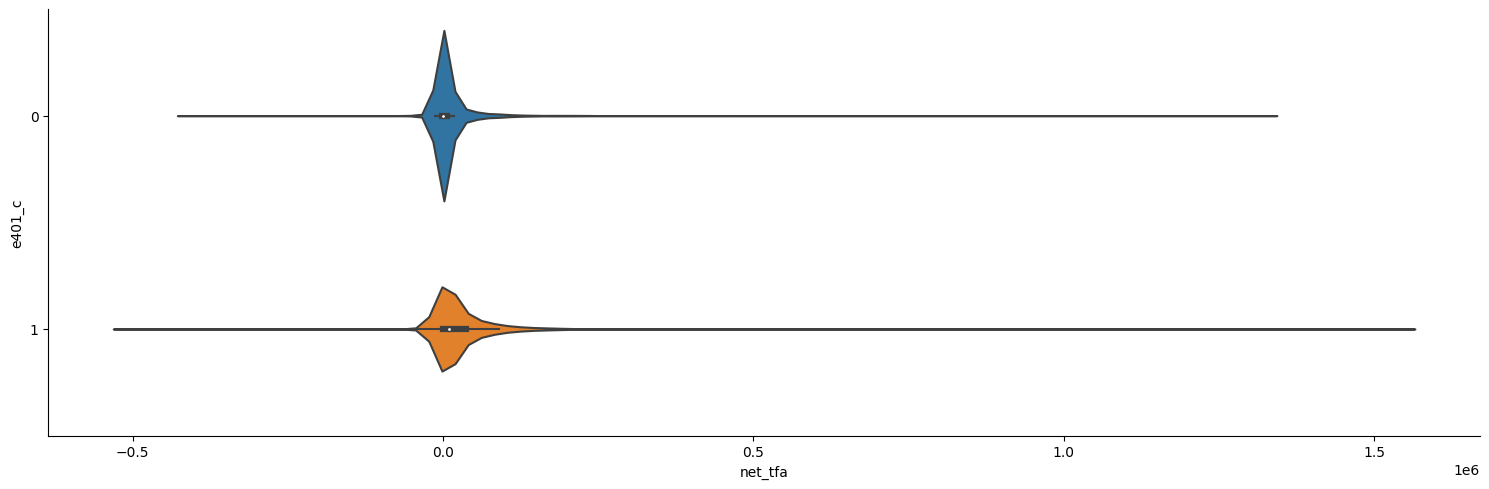

In [7]:
df['e401_c'] = df['e401'].astype('category')
sns.catplot(data=df, y="e401_c", x="net_tfa", kind="violin", height=5, aspect=3)
#sns.catplot(data=df, x="e401", y="net_tfa", alpha=0.1)

In [8]:
smf.ols('net_tfa ~ e401', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.079e+04,795.683,13.558,0.000,9228.343,1.23e+04
e401,1.956e+04,1305.704,14.980,0.000,1.7e+04,2.21e+04


In [9]:
# Fit a linear regression model with controls for the other potential confounders
smf.ols('net_tfa ~ e401 + age + inc + fsize + educ + pira + hown + marr + db + twoearn', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.291e+04,4276.223,-7.695,0.000,-4.13e+04,-2.45e+04
e401,5896.1984,1250.014,4.717,0.000,3445.917,8346.480
age,624.1455,59.521,10.486,0.000,507.472,740.819
inc,0.9357,0.030,30.982,0.000,0.876,0.995
fsize,-1018.7979,449.859,-2.265,0.024,-1900.614,-136.982
educ,-639.7538,228.499,-2.800,0.005,-1087.659,-191.848
pira,2.953e+04,1465.830,20.148,0.000,2.67e+04,3.24e+04
hown,1185.2564,1323.687,0.895,0.371,-1409.439,3779.952
marr,743.3445,1795.556,0.414,0.679,-2776.310,4262.999
db,-4904.5684,1359.098,-3.609,0.000,-7568.677,-2240.460


## Train a single ML model to predict outcomes

In [10]:
# Train a single ML model
single_model = XGBRegressor()
single_model.fit(df[X + [T]], df[Y])
# Predict the outcome for both possible treatment values
X0 = df[X + [T]].copy(); X0[T] = 0
X1 = df[X + [T]].copy(); X1[T] = 1
df['y0'] = single_model.predict(X0)
df['y1'] = single_model.predict(X1)
# Compute the difference in outcomes
df['y_diff'] = df['y1'] - df['y0'];

count      9915.000000
mean       7299.479980
std       16029.632812
min     -321230.718750
25%        2508.416504
50%        5210.951172
75%       10587.274414
max      357415.468750
Name: y_diff, dtype: float64

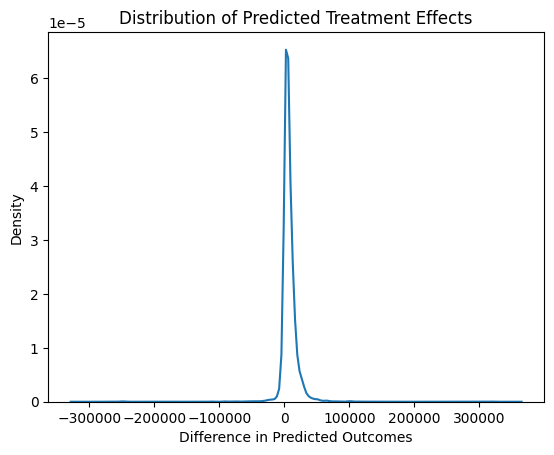

In [11]:
sns.kdeplot(df, x="y_diff")
plt.xlabel("Difference in Predicted Outcomes")
plt.title("Distribution of Predicted Treatment Effects");
df['y_diff'].describe()

## Train Treatment and Outcome ML models, without cross fitting

In [12]:
# Fit model to predict T
treatment_model = XGBClassifier()
treatment_model.fit(df[X], df[T])
T_pred = treatment_model.predict_proba(df[X])[:,1]
T_resid = df[T] - T_pred

# Plot Y against the T residuals
#sns.regplot(data=df, x=T_resid, y=Y, scatter_kws={'alpha': 0.1}, line_kws={'color': 'red'});

In [13]:
# Fit model to predict Y
outcome_model = XGBRegressor()
outcome_model.fit(df[X], df[Y])
Y_pred = outcome_model.predict(df[X])
Y_resid = df[Y] - Y_pred

# Plot Y residuals against the T residuals
#sns.regplot(x=T_resid, y=Y_resid, scatter_kws={'alpha': 0.1}, line_kws={'color': 'red'});

In [14]:
# Fit linear model to predict Y_resid based on T_residual
sm.OLS(Y_resid, T_resid).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
e401,7241.0850,599.888,12.071,0.000,6065.184,8416.987


# Train Treatment and Outcome ML models using Cross-splitting

In [22]:
# Cross_val_predict splits the data into 2 parts and then returns out-of-sample predictions for each part (trained on the other part)
df1, df2 = train_test_split(df, test_size=0.5, random_state=0)

# Fit model to predict T on first half
treatment_model_1 = XGBClassifier()
treatment_model_1.fit(df1[X], df1[T])
T_pred_2 = treatment_model_1.predict_proba(df2[X])[:,1]
T_resid_2 = df2[T] - T_pred_2

# Fit model to predict T on second half
treatment_model_2 = XGBClassifier()
treatment_model_2.fit(df2[X], df2[T])
T_pred_1 = treatment_model_2.predict_proba(df1[X])[:,1]
T_resid_1 = df1[T] - T_pred_1

# Fit model to predict Y on first half
outcome_model_1 = XGBRegressor()
outcome_model_1.fit(df1[X], df1[Y])
Y_pred_2 = outcome_model_1.predict(df2[X])
Y_resid_2 = df2[Y] - Y_pred_2

# Fit model to predict Y on second half
outcome_model_2 = XGBRegressor()
outcome_model_2.fit(df2[X], df2[Y])
Y_pred_1 = outcome_model_2.predict(df1[X])
Y_resid_1 = df1[Y] - Y_pred_1


In [33]:
# Results from first half, using predictions from second half
sm.OLS(Y_resid_1, T_resid_1).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
e401,9168.3266,2020.203,4.538,0.000,5207.835,1.31e+04


In [34]:
# Results from second half, using predictions from first half
sm.OLS(Y_resid_2, T_resid_2).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
e401,1.014e+04,2067.899,4.906,0.000,6090.973,1.42e+04


In [35]:
# Stacking the results from the two halves and then fitting the final model
T_resid_stacked = np.hstack([T_resid_1, T_resid_2])
Y_resid_stacked = np.hstack([Y_resid_1, Y_resid_2])
sm.OLS(Y_resid_stacked, T_resid_stacked).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
x1,9663.1748,1445.624,6.684,0.000,6829.458,1.25e+04


## Using Sklearn cross_val_predict

In [36]:
# Cross_val_predict splits the data into 5 parts and then returns out-of-sample predictions for each part (trained on the other 4 parts)
cv = 5
splitter = KFold(n_splits=cv, shuffle=True, random_state=0)

# Fit model to predict T
treatment_model = XGBClassifier()
T_pred = cross_val_predict(treatment_model, df[X], df[T], cv=splitter, method='predict_proba')[:, 1]
T_resid = df[T] - T_pred

# Fit model to predict Y
outcome_model = XGBRegressor()
Y_pred = cross_val_predict(outcome_model, df[X], df[Y], cv=splitter)
Y_resid = df[Y] - Y_pred

# Fit linear regression on the residuals
sm.OLS(Y_resid, T_resid).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
e401,9101.8785,1369.732,6.645,0.000,6416.925,1.18e+04


### Repeating with RandomForest instead of XGBoost

In [37]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Fit model to predict T
treatment_model = RandomForestClassifier()
T_pred = cross_val_predict(treatment_model, df[X], df[T], cv=splitter, method='predict_proba')[:, 1]
T_resid = df[T] - T_pred

# Fit model to predict Y
outcome_model = RandomForestRegressor()
Y_pred = cross_val_predict(outcome_model, df[X], df[Y], cv=splitter)
Y_resid = df[Y] - Y_pred

# Fit linear regression on the residuals
sm.OLS(Y_resid, T_resid).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
e401,9254.8338,1269.165,7.292,0.000,6767.012,1.17e+04


# Using the EconML Package

In [17]:
model = LinearDML(
    model_y=XGBRegressor(),
    model_t=XGBClassifier(),
    discrete_treatment=True,
    cv=5,
)
model.fit(df[Y], df[T], X=None, W=df[X]);

In [18]:
model.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,8580.185,1491.397,5.753,0.0,5657.1,11503.27
